### VIX Clustering using KMeans

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

#### Download VIX and SPY data

In [2]:
data = yf.download("^VIX SPY", start="1995-01-01", end="2020-12-31")

[*********************100%***********************]  2 of 2 completed


In [3]:
data.head()

Adj Close             Close              High               Low  \
                  SPY   ^VIX        SPY   ^VIX        SPY   ^VIX        SPY   
Date                                                                          
1995-01-03  28.293339  14.25  45.781250  14.25  45.843750  14.71  45.687500   
1995-01-04  28.428526  13.53  46.000000  13.53  46.000000  14.15  45.750000   
1995-01-05  28.428526  13.50  46.000000  13.50  46.109375  14.19  45.953125   
1995-01-06  28.457483  13.13  46.046875  13.13  46.250000  13.76  45.906250   
1995-01-09  28.486477  13.33  46.093750  13.33  46.093750  14.08  46.000000   

                        Open         Volume       
             ^VIX        SPY   ^VIX     SPY ^VIX  
Date                                              
1995-01-03  13.39  45.703125  14.09  324300    0  
1995-01-04  13.53  45.984375  13.87  351800    0  
1995-01-05  13.37  46.031250  13.70   89800    0  
1995-01-06  12.79  46.093750  13.67  448400    0  
1995-01-09  13.21  46.031250  13.53   36800    0

#### Data Transformation

In [4]:
data_unstack = data.stack(level=0).reset_index(level=1)

In [5]:
data_final = data_unstack[data_unstack["level_1"] == "Adj Close"]

In [6]:
data_final = data_final.rename(columns={"^VIX": "VIX"})

In [7]:
data_final = data_final.drop(columns = "level_1")

In [8]:
data_final["SPY_PCT"] = data_final["SPY"].pct_change()

In [9]:
data_final.describe().T

,count,mean,std,min,25%,50%,75%,max
SPY,6546.0,124.311851,74.411742,28.293339,76.247866,95.669174,168.484421,369.745392
VIX,6546.0,20.008501,8.506933,9.140000,13.780000,18.224999,23.650000,82.690002
SPY_PCT,6545.0,0.000467,0.012218,-0.109424,-0.004561,0.000718,0.006139,0.145198


#### Plotting raw values and SPY percent change
- The second plot shows that spikes in VIX coincide with high volatility in SPY (percent changes)

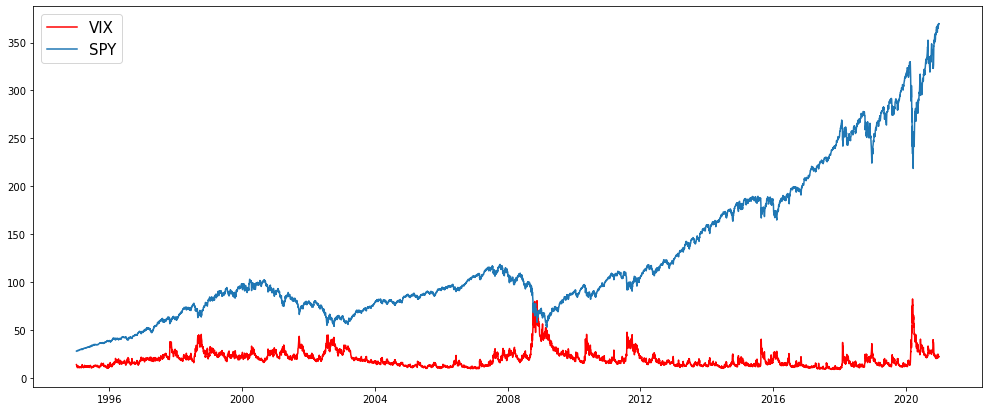

In [10]:
plt.figure(figsize=(17,7))
plt.plot( data_final.index, data_final["VIX"], label = "VIX", color = "red")
plt.plot( data_final.index, data_final["SPY"], label = "SPY")
plt.legend(fontsize=15)
plt.show()


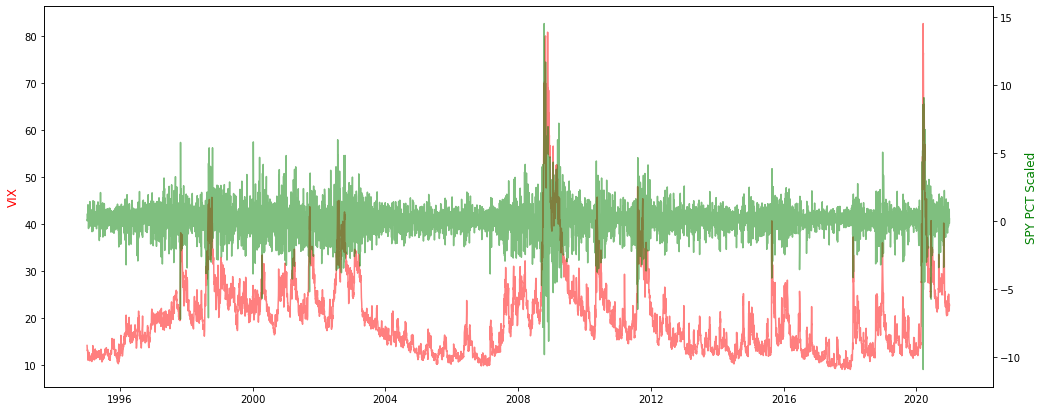

In [11]:
fig,ax = plt.subplots(figsize=(17,7))

ax.plot(data_final.index, data_final["VIX"],color="red",alpha = 0.5)
ax.set_ylabel("VIX",color="red",fontsize=12)

ax2=ax.twinx()
ax2.plot(data_final.index, data_final["SPY_PCT"]*100,color="green", alpha=0.5)
ax2.set_ylabel("SPY PCT Scaled",color="green",fontsize=12)

plt.show()

#### K-Means Clustering 
- Scale and transform VIX data
- Calculate and plot Sum of Squared Deviations (SSD) to determine appropriate number of clusters using elbow method
- Plot clustered data for final subset of choices for number of clusters (3 and 4)

In [12]:
vix = data_final["VIX"].to_numpy()

In [13]:
from sklearn.preprocessing import StandardScaler
vix_sc = np.reshape(vix, [-1,1])
scaler = StandardScaler().fit(vix_sc)
vix_scaled = scaler.transform(vix_sc)


In [14]:
from sklearn.cluster import KMeans

ssd = []
for k in range(2,10):
    model = KMeans(n_clusters=k)
    model.fit(vix_scaled)
    ssd.append(model.inertia_)

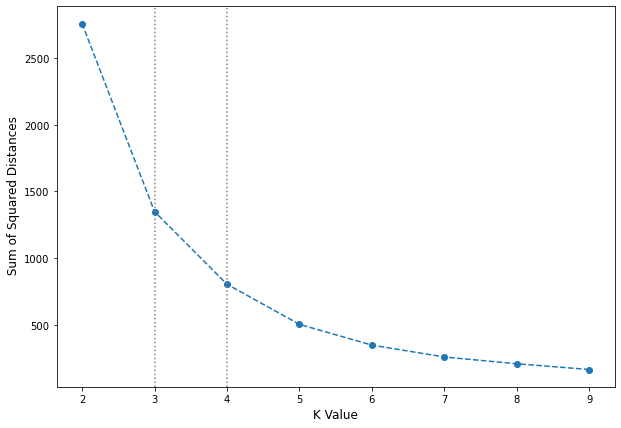

In [26]:
plt.figure(figsize=(10,7))
plt.plot(range(2,10),ssd,'o--')
plt.xlabel("K Value",fontsize=12)
plt.ylabel(" Sum of Squared Distances",fontsize=12)
plt.axvline(x=3, color='grey', linestyle='dotted')
plt.axvline(x=4, color='grey', linestyle='dotted');


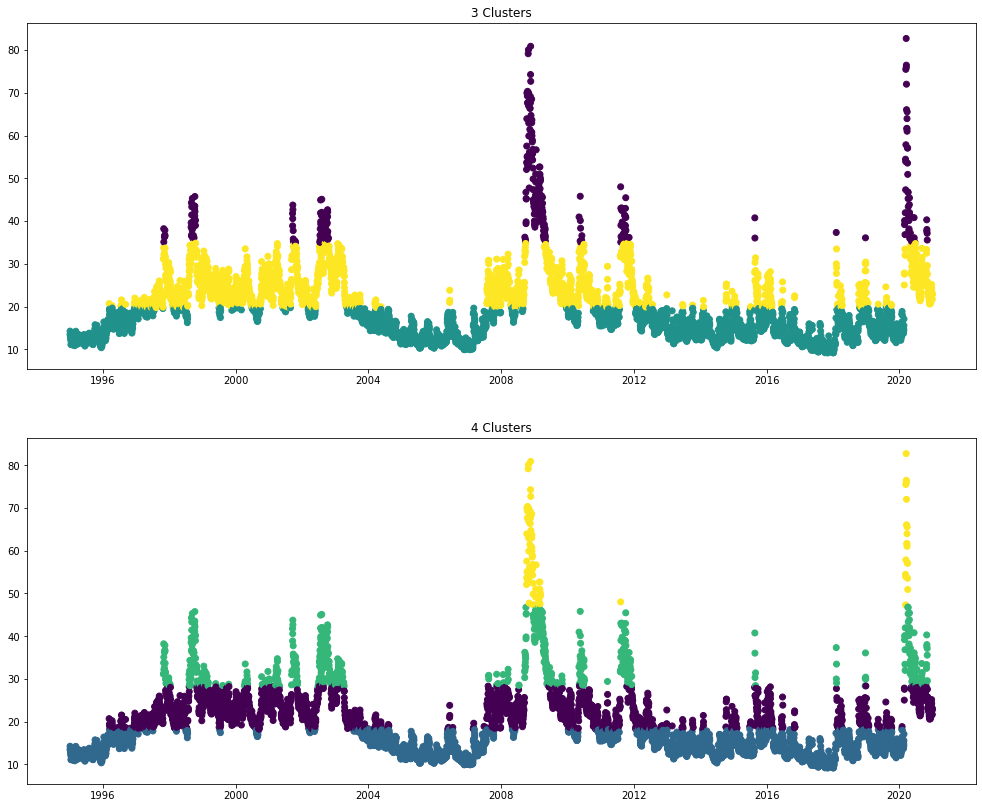

In [16]:
k_best = [3, 4]
fig, axs = plt.subplots(len(k_best), 1)
fig.set_size_inches(17,7*len(k_best))
ind = 0
for kk in k_best:
    kmeans = KMeans(n_clusters=kk, random_state=0).fit(vix_scaled)  
    axs[ind].scatter(  data_final.index, data_final["VIX"], c=kmeans.labels_)
    axs[ind].set_title(str(kk)+" Clusters") 
    ind = ind + 1
plt.show()

#### Determine final number of clusters to use
- To decide between 3 and 4 clusters, assign cluster labels to data and determine SPY percent change across clusters
- Chose 3 as the final number of clusters as it provides clear separation in the SPY percent change and variations across clusters

In [29]:
### function to assign cluster labels and plot SPY percent change across clusters
def add_clusters_to_data(num_clusters):
    labels = pd.Series(KMeans(n_clusters=num_clusters).fit(vix_scaled).labels_, name = "Cluster_Label").reset_index()
    spy_check = pd.concat([data_final.reset_index(),labels], axis = 1)
    spy_check = spy_check.replace({"Cluster_Label": dict(zip(list(spy_check.groupby("Cluster_Label").describe()["SPY"]["mean"].sort_values().index),["Grp 1", "Grp 2", "Grp 3", "Grp 4"]))})
    
    plt.figure(figsize=(17,7), dpi=200)
    sns.boxplot(x='Cluster_Label',y='SPY_PCT',data=spy_check,orient='v');
    
    

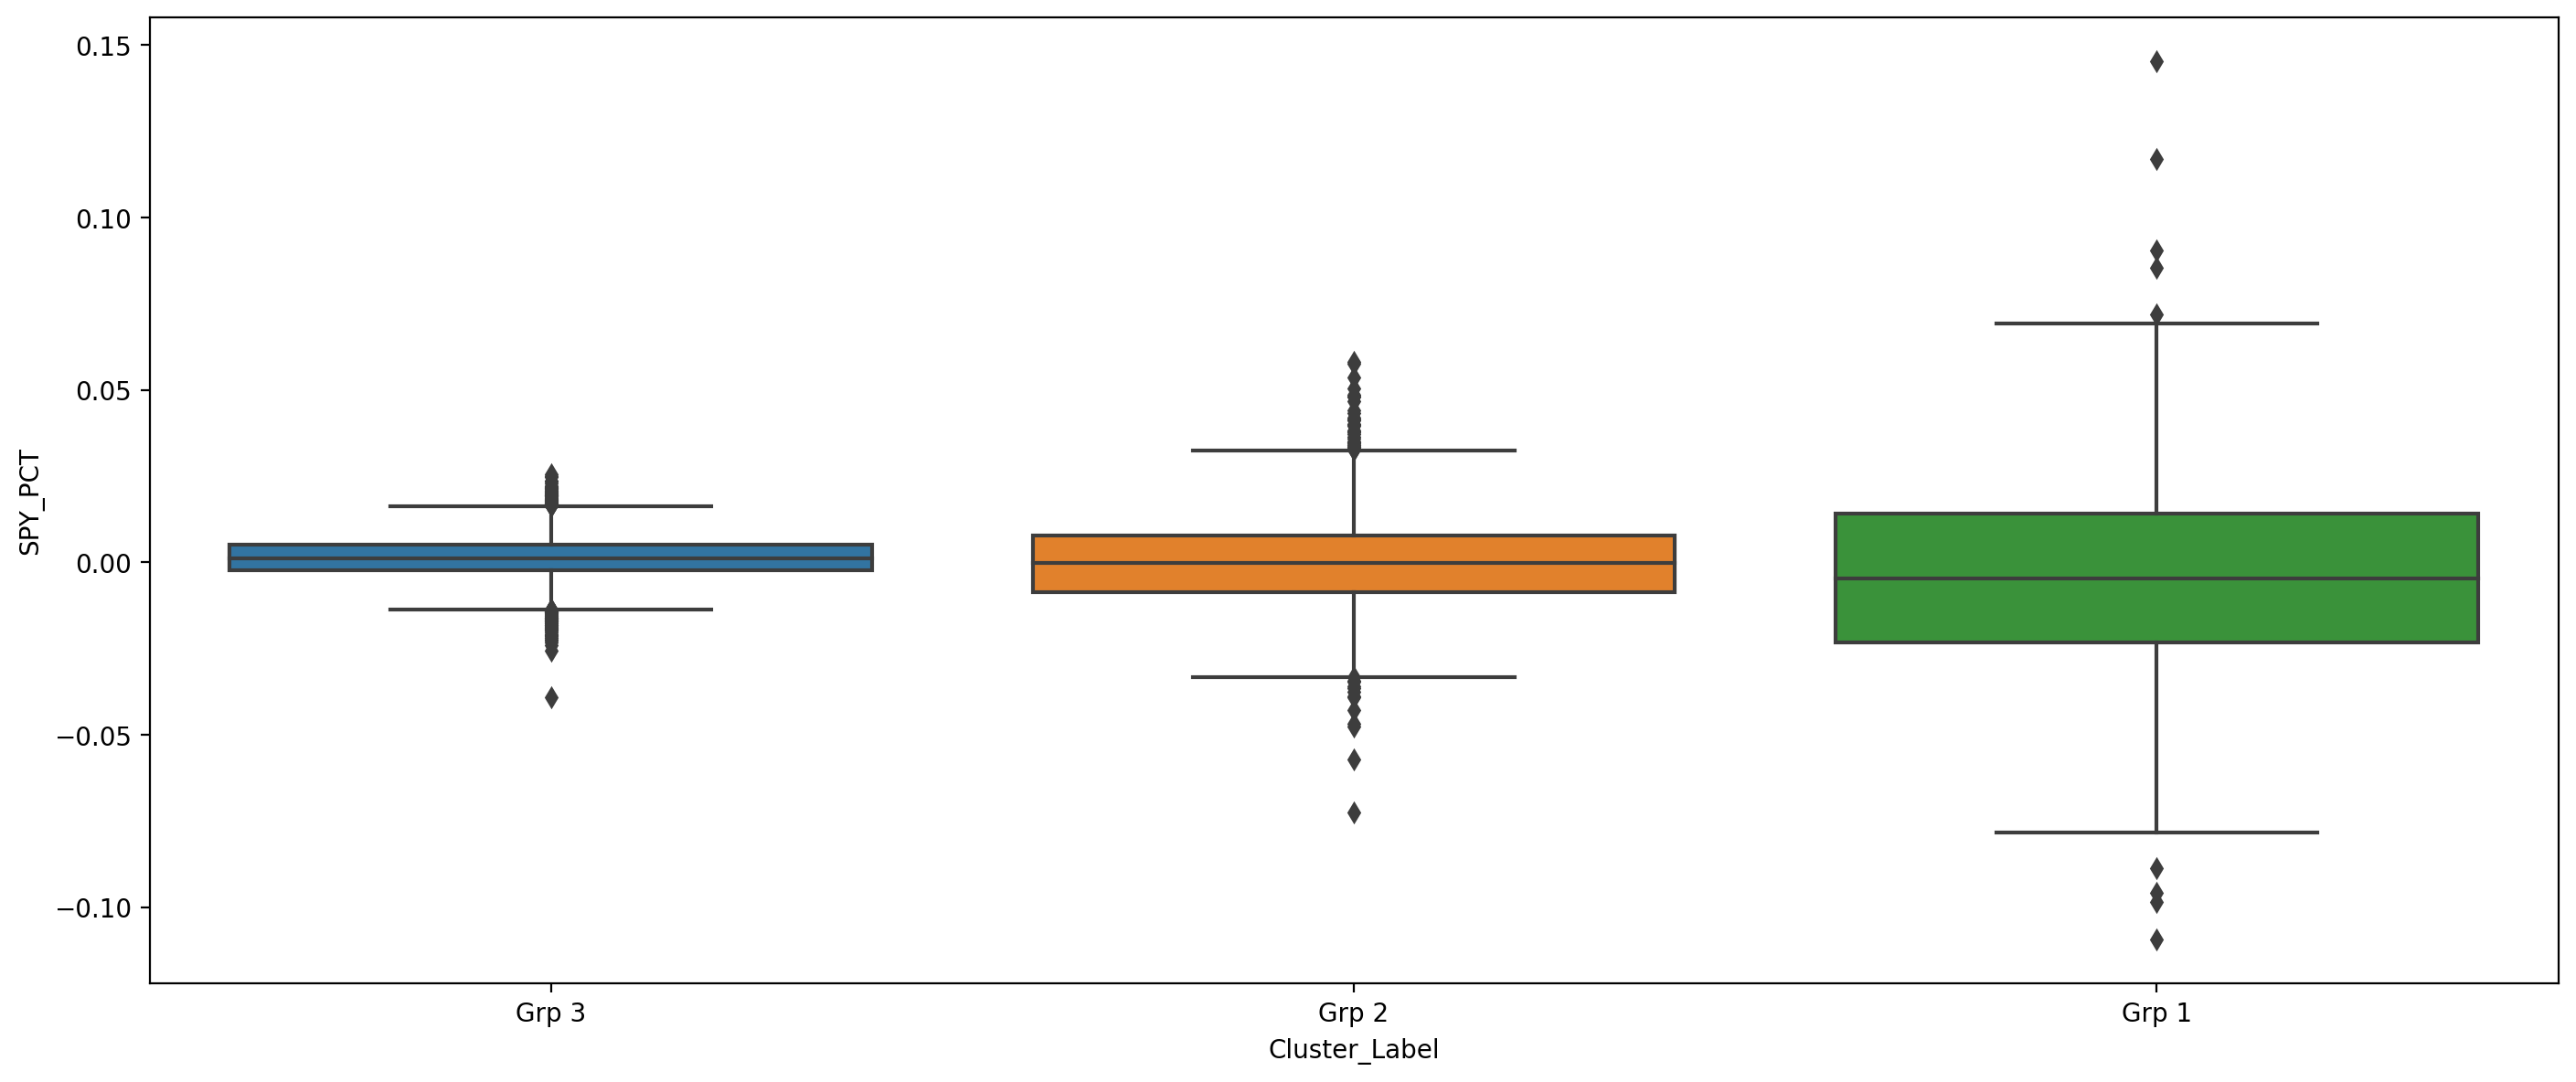

In [30]:
add_clusters_to_data(3)

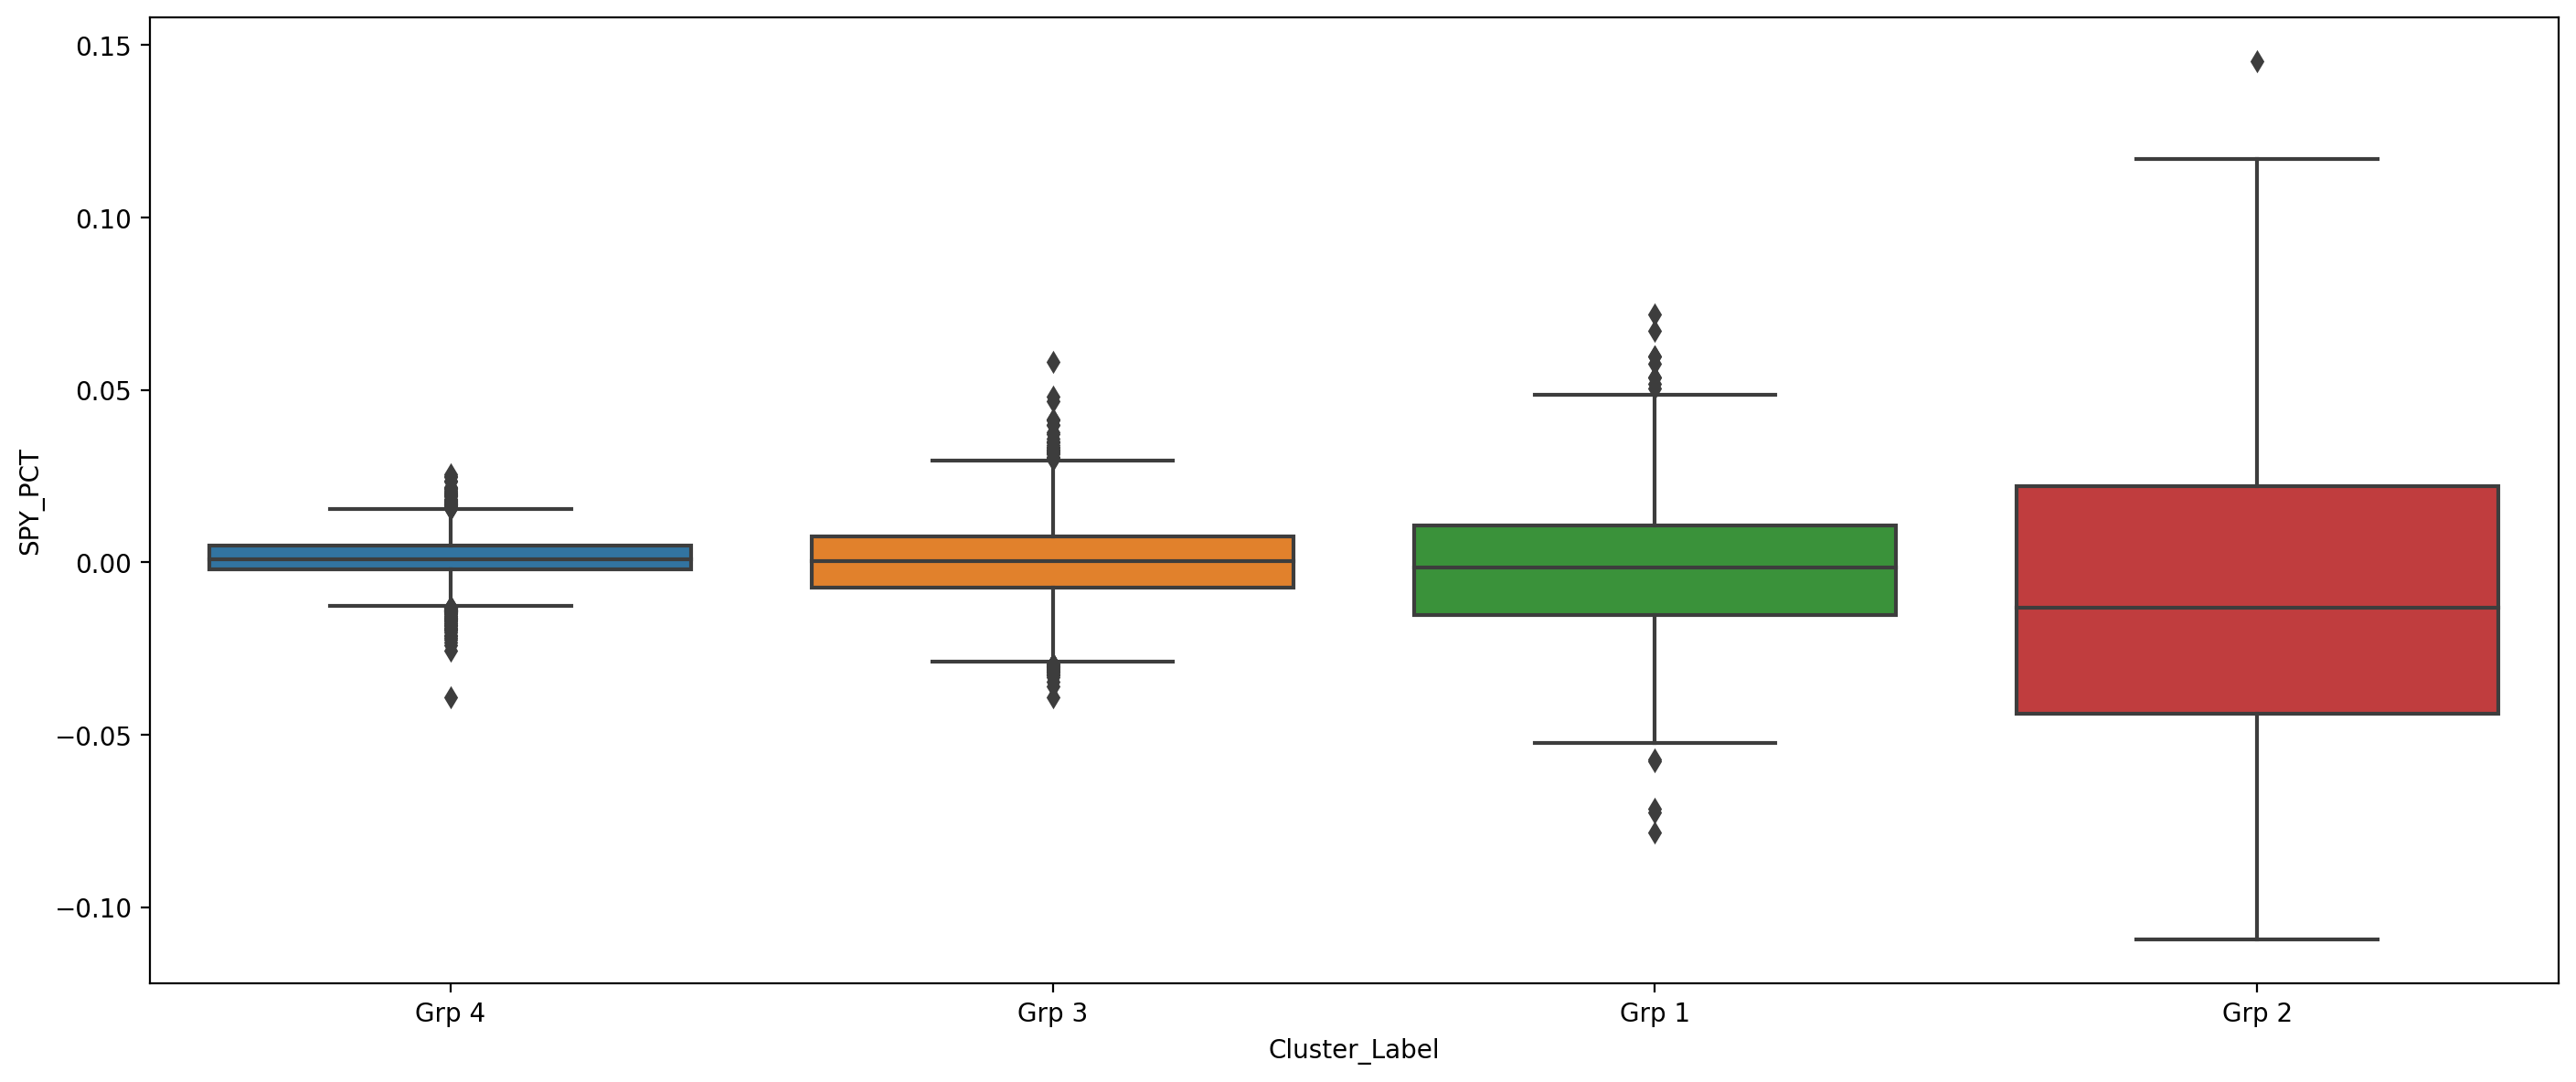

In [31]:
add_clusters_to_data(4)